# **MP3_report_59**

##**組員與分工**

組員: 林群佑, 刁一平

|      工作項目      |      分工     |
|:------------------:|:-------------:|
|   Trace Code   |     刁一平    |
|      功能實作與除錯      |     林群佑    |

## Trace Code

 ### 1-1. New→Ready

#### Kernel::ExecAll()

In [ ]:
void Kernel::ExecAll() {
    for (int i = 1; i <= execfileNum; i++) {
        int a = Exec(execfile[i]);
    }
    currentThread->Finish();
    // Kernel::Exec();
}

將所有待辦的程式放入執行(呼叫 Exec() 函式)，執行完後呼叫 currentThread->Finish() 來表示完成所有待辦程式

#### Kernel::Exec(char*)

In [ ]:
int Kernel::Exec(char *name) {
    t[threadNum] = new Thread(name, threadNum); # NEW
    t[threadNum]->setIsExec();
    t[threadNum]->space = new AddrSpace();
    t[threadNum]->Fork((VoidFunctionPtr)&ForkExecute, (void *)t[threadNum]);
    threadNum++;

    return threadNum - 1;
}

建⽴new thread，設定thread的 AddrSpace，呼叫 Fork() 將其 fork

#### Thread::Fork(VoidFunctionPtr, void*)

In [ ]:
void Thread::Fork(VoidFunctionPtr func, void *arg) {
    //omit

    StackAllocate(func, arg);
    oldLevel = interrupt->SetLevel(IntOff);
    scheduler->ReadyToRun(this);  // ReadyToRun assumes that interrupts are disabled!
    (void)interrupt->SetLevel(oldLevel);
    //omit
}


在Fork()裡，會先以StackAllocate()分配一塊 stack 給這個thread，接著就以
ReadyToRun()將這個 thread 加進 ready queue 裡

####  Thread::StackAllocate(VoidFunctionPtr, void*)

In [ ]:
void Thread::StackAllocate(VoidFunctionPtr func, void *arg) {
    stack = (int *)AllocBoundedArray(StackSize * sizeof(int));
// omit
// 處理 stack top ,  將 ThreadRoot 存入 Kernel Registers

這個函式就是呼叫 AllocBoundedArray() 分配空間給 stack 和初始化 stack ，而 stack top 需針對不同作業系統有不同處理

#### Scheduler::ReadyToRun(Thread*)

In [ ]:
void Scheduler::ReadyToRun(Thread *thread) {
    ASSERT(kernel->interrupt->getLevel() == IntOff);//檢查 interrupt 功能是否已經關閉中斷，若無則報錯
    thread->setStatus(READY); # READY
    readyList->Append(thread); # insert to ready list
}

在ReadyToRun()裡，確保interrupt被關閉, 會將thread 狀態設為ready，並加進ready queue裡。

###  1-2. Running→Ready


####  Machine::Run()

In [ ]:
void Machine::Run() {
    Instruction *instr = new Instruction;  // storage for decoded instruction
    kernel->interrupt->setStatus(UserMode);
    for (;;) {
        OneInstruction(instr);
        kernel->interrupt->OneTick();
    }
}

這部分檢查有哪些指令輸入，模擬程式執行的解碼過程 instr 就是 User Program 的某一行程式碼 OneTick() 就是模擬 CPU Clock 往前跑的情形

####  Interrupt::OneTick()

In [ ]:
Interrupt::OneTick()
{
    MachineStatus oldStatus = status;
    Statistics *stats = kernel->stats;

// advance simulated time
    if (status == SystemMode) {
      stats->totalTicks += SystemTick; # SystemTick = 10
      stats->systemTicks += SystemTick;
    } else {
      stats->totalTicks += UserTick; # UserTick = 1
      stats->userTicks += UserTick;
    }
    DEBUG(dbgInt, "== Tick " << stats->totalTicks << " ==");

// check any pending interrupts are now ready to fire  # ChangeLevel: 改變interupt狀態
    ChangeLevel(IntOn, IntOff); // first, turn off interrupts
                // (interrupt handlers run with
                // interrupts disabled)
    CheckIfDue(FALSE);      // check for pending interrupts
    ChangeLevel(IntOff, IntOn); // re-enable interrupts
    if (yieldOnReturn) {    // if the timer device handler asked
                    // for a context switch, ok to do it now
    yieldOnReturn = FALSE;
    status = SystemMode;        // yield is a kernel routine
    kernel->currentThread->Yield();
    status = oldStatus;
    }
}

用來模擬系統中時間的推進，並檢查是否有需要觸發的 pending interrupts
根據當前系統處於system mode或user mode，來決定kernel的推進時間,SystemTick（10）或UserTick（1）

進入CheckIfDue去檢查是否⽬前有需要執⾏的的pending interrupt

如果當前要求進行context switch，則將 yieldOnReturn設為FALSE,並呼叫currentThread的 Yield(),當此thread⼜可以執⾏時，則恢復 status

總結來說,檢查有沒有hardware interrupt要執行，最後檢查timer是否要求context switch，如果需要則會呼叫Yield()

####  Thread::Yield()

In [ ]:
void Thread::Yield() {
    Thread *nextThread;
    IntStatus oldLevel = kernel->interrupt->SetLevel(IntOff);

    ASSERT(this == kernel->currentThread);

    DEBUG(dbgThread, "Yielding thread: " << name);

    nextThread = kernel->scheduler->FindNextToRun();
    if (nextThread != NULL) {
        kernel->scheduler->ReadyToRun(this);
        kernel->scheduler->Run(nextThread, FALSE);
    }
    (void)kernel->interrupt->SetLevel(oldLevel);
}

呼叫FindNextToRun()尋找下一個在ready state 的 thread 來
執行，再呼叫ReadyToRun()將現在這個thread重新加回ready queue裡面，最後呼叫Run()執行context switch

#### Scheduler::FindNextToRun()

In [ ]:
Thread *
Scheduler::FindNextToRun() {
    ASSERT(kernel->interrupt->getLevel() == IntOff);
    if (readyList->IsEmpty()) { # no thread ready to run
        return NULL;
    } else {
        return readyList->RemoveFront();
    }
}

先確保interrupt被關閉,在ready list中尋找下一個可執行的thread,若無則回傳NULL

#### Scheduler::ReadyToRun(Thread*)

In [ ]:
void Scheduler::ReadyToRun(Thread *thread) {
    ASSERT(kernel->interrupt->getLevel() == IntOff);//檢查 interrupt 功能是否已經關閉中斷，若無則報錯
    DEBUG(dbgThread, "Putting thread on ready list: " << thread->getName());
    // cout << "Putting thread on ready list: " << thread->getName() << endl ;
    thread->setStatus(READY);
    readyList->Append(thread);
}

先確保interrupt被關閉,將thread設為ready並將其放入readyList

#### Scheduler::Run(Thread*, bool)

In [ ]:
void Scheduler::Run(Thread *nextThread, bool finishing) {
    Thread *oldThread = kernel->currentThread;

    ASSERT(kernel->interrupt->getLevel() == IntOff);//檢查 interrupt 功能是否已經關閉中斷，若無則報錯

    if (finishing) {  // mark that we need to delete current thread
        ASSERT(toBeDestroyed == NULL);
        toBeDestroyed = oldThread;
    }

    if (oldThread->space != NULL) {  // if this thread is a user program,
        oldThread->SaveUserState();  // save the user's CPU registers
        oldThread->space->SaveState();
    }

    oldThread->CheckOverflow();  // check if the old thread
                                 // had an undetected stack overflow

    kernel->currentThread = nextThread;  // switch to the next thread
    nextThread->setStatus(RUNNING);      // nextThread is now running

    DEBUG(dbgThread, "Switching from: " << oldThread->getName() << " to: " << nextThread->getName());

    // This is a machine-dependent assembly language routine defined
    // in switch.s.  You may have to think
    // a bit to figure out what happens after this, both from the point
    // of view of the thread and from the perspective of the "outside world".

    SWITCH(oldThread, nextThread);

    // we're back, running oldThread

    // interrupts are off when we return from switch!
    ASSERT(kernel->interrupt->getLevel() == IntOff);

    DEBUG(dbgThread, "Now in thread: " << oldThread->getName());

    CheckToBeDestroyed();  // check if thread we were running
                           // before this one has finished
                           // and needs to be cleaned up

    if (oldThread->space != NULL) {     // if there is an address space
        oldThread->RestoreUserState();  // to restore, do it.
        oldThread->space->RestoreState();
    }
}

首先查看當前 process 的 Process Control Block 中的 finish 變數檢查是否已完成，若已完成，則將其放入 toBeDestroyed 這樣之後便會刪除，接著，如果程式是 user program，則須將其資料儲存起來，接著檢查舊 process ( oldThread )是否有 stack overflow ，然後將當前執行緒切換到下一個 Process Control Block 的 process ，並將狀態設為 RUNNING ，再呼叫 SWITCH(oldThread, nextThread) 函式完成當前執行緒工作切換，完成交換後，呼叫 CheckToBeDestroyed() 來檢查是否有執行完成需要被回收掉的程式，最後檢查舊 Process Control Block ( oldThread )是否還有資料(還未完成)，如果有，將資料存回舊 Process Control Block ( oldthread )讓執行緒回來執行 oldthread process 時能從 Process Control Block 中找到資料位置


### 1-3. Running→Waiting

####  SynchConsoleOutput::PutChar(char)

In [ ]:
void SynchConsoleOutput::PutChar(char ch)
{
    lock->Acquire();
    consoleOutput->PutChar(ch);
    waitFor->P();
    lock->Release();
}

# 下方為lock 之code
void Lock::Acquire()
{
    semaphore->P();
    lockHolder = kernel->currentThread;
}
void Lock::Release()
{
    ASSERT(IsHeldByCurrentThread());
    lockHolder = NULL;
    semaphore->V();
}

為了確保多個thread不會同時寫入，這裡使用了lock機制 lock->Acquire() 來保護對輸出的權限, 當一個thread獲得了這個鎖後，其他thread需要等待該鎖release後才能繼續

lock->Acquire(): 取得 lock,  來達到同時間只會有⼀個 writer, 拿到 lock 的
thread 才能執⾏


waitfor->P(): 等待 semaphore value > 0 ( wait for callBack )
lock->Release(),　釋放 lock

####  Semaphore::P()

In [ ]:
void Semaphore::P()
{
    DEBUG(dbgTraCode, "In Semaphore::P(), " << kernel->stats->totalTicks);
    Interrupt *interrupt = kernel->interrupt;
    Thread *currentThread = kernel->currentThread;

    // disable interrupts
    IntStatus oldLevel = interrupt->SetLevel(IntOff);

    while (value == 0) {        // semaphore not available
    queue->Append(currentThread);   // so go to sleep
    currentThread->Sleep(FALSE);
    }
    value--;    // semaphore available, consume its value

    // re-enable interrupts
    (void) interrupt->SetLevel(oldLevel);
}

關閉interrupt確保接下來的操作不被context switch中斷


如果現在的value為0，將current thread 放到 queue 的尾端並使其Sleep,以FALSE傳入, 代表進入waiting state

將value -1後恢復interrupt

####  List<T>::Append(T)

In [ ]:
void List<T>::Append(T item)
{
    ListElement<T> *element = new ListElement<T>(item);
    ASSERT(!IsInList(item));
    if (IsEmpty()) {    // list is empty
        first = element;
        last = element;
    }
    else {              // else put it after last
        last->next = element;
        last = element;
    }
    numInList++;
    ASSERT(IsInList(item));
}

在Append()會將傳入的thread存到list的最尾端

#### Thread::Sleep(bool)

In [ ]:
void Thread::Sleep(bool finishing) {
    Thread *nextThread;

    ASSERT(this == kernel->currentThread);
    ASSERT(kernel->interrupt->getLevel() == IntOff);

    DEBUG(dbgThread, "Sleeping thread: " << name);
    DEBUG(dbgTraCode, "In Thread::Sleep, Sleeping thread: " << name << ", " << kernel->stats->totalTicks);

    status = BLOCKED;
    // cout << "debug Thread::Sleep " << name << "wait for Idle\n";
    while ((nextThread = kernel->scheduler->FindNextToRun()) == NULL) {
        kernel->interrupt->Idle();  // no one to run, wait for an interrupt
    }
    // returns when it's time for us to run
    kernel->scheduler->Run(nextThread, finishing);
}

將狀態設為blocked，直到有其他thread來叫醒他，並將他放回ready queue 裡進行重新排程,

而此時若沒有其他thread 在ready queue
裡，就會呼叫Idle()表示現在CPU在閒置中，直到找到下一個thread並呼叫
Run()來進行context switch

####  Scheduler::FindNextToRun()

先確保interrupt被關閉,在ready list中尋找下一個可執行的thread,若無則回傳NULL

#### Scheduler::Run(Thread*, bool)

參照先前之段落

###  1-4. Waiting→Ready

####  Semaphore::V()

In [ ]:
void Semaphore::V()
{
    DEBUG(dbgTraCode, "In Semaphore::V(), " << kernel->stats->totalTicks);
    Interrupt *interrupt = kernel->interrupt;

    // disable interrupts
    IntStatus oldLevel = interrupt->SetLevel(IntOff);

    if (!queue->IsEmpty()) {  // make thread ready.
    kernel->scheduler->ReadyToRun(queue->RemoveFront()); # READY
    }
    value++;

    // re-enable interrupts
    (void) interrupt->SetLevel(oldLevel);
}

從queue裡叫醒一個waiting中的thread，並呼叫ReadyToRun()，
使其設為ready state，再將value+1，表示釋放出CPU資源

#### Scheduler::ReadyToRun(Thread*)

將thread設為ready並將其放入readyList

### 1-5. Running→Terminated

#### ExceptionHandler(ExceptionType) case SC_Exit

In [ ]:
void ExceptionHandler(ExceptionType which) {
    char ch;
    int val;
    int type = kernel->machine->ReadRegister(2);
    int status, exit, threadID, programID, fileID, numChar;
    DEBUG(dbgSys, "Received Exception " << which << " type: " << type << "\n");
    DEBUG(dbgTraCode, "In ExceptionHandler(), Received Exception " << which << " type: " << type << ", " << kernel->stats->totalTicks);
    switch (which) {
        case SyscallException:
            switch (type) {
                case SC_Exit:
                    DEBUG(dbgAddr, "Program exit\n");
                    val = kernel->machine->ReadRegister(4);
                    cout << "return value:" << val << endl;
                    kernel->currentThread->Finish();
                    break;
                }
    ASSERTNOTREACHED();
}

從4號register讀出程序的回傳值,呼叫Finish()來結束目前這個thread

####  Thread::Finish()

In [ ]:
void Thread::Finish() {
    (void)kernel->interrupt->SetLevel(IntOff);
    ASSERT(this == kernel->currentThread);

    DEBUG(dbgThread, "Finishing thread: " << name);
    if (kernel->execExit && this->getIsExec()) {
        kernel->execRunningNum--;
        if (kernel->execRunningNum == 0) {
            kernel->interrupt->Halt();
        }
    }
    Sleep(TRUE);  // invokes SWITCH
    // not reached
}

首先關閉 interrupt ，然後檢查是否所有執行緒已經停止以及當前程式是否完成，當所有執行緒已經停止且當前執行緒工作完成則將紀錄有多少程式在運行的變數減一，當變數為0時，代表已經沒有任何 process 在執行，此時便呼叫 kernel->interrupt->Halt() 結束 NachOS 運作，而若還有 process 在運作則呼叫 Sleep(TRUE) ，代表當前執行緒進入休息狀態

#### Thread::Sleep(bool)

在Finish()裡會呼叫Sleep()，參數為TRUE代表thread 結束

####  Scheduler::FindNextToRun()

參照先前之段落

#### Scheduler::Run(Thread*, bool)

參照先前之段落

### 1-6. Ready→Running

###  Scheduler::FindNextToRun()

參照先前之段落

####  Scheduler::Run(Thread*, bool)

呼叫SWITCH()來進行context switch

#### SWITCH(Thread *,  Thread *)

In [ ]:
8(esp) ->  thread *t2
4(esp) ->  thread *t1
(esp) ->  return address

esp指向的記憶體存著return address

esp+4指向的記憶體存著oldThread的address

esp+8 指向的記憶體存著nextThread的address

In [ ]:
eax     points to startup function (interrupt enable)
edx     contains inital argument to thread function
esi     points to thread function
edi     point to Thread::Finish()

In [ ]:
  _SWITCH:
SWITCH:
        movl    %eax,_eax_save          # save the value of eax
        movl    4(%esp),%eax            # move pointer to t1 into eax
        movl    %ebx,_EBX(%eax)         # save registers
        movl    %ecx,_ECX(%eax)
        movl    %edx,_EDX(%eax)
        movl    %esi,_ESI(%eax)
        movl    %edi,_EDI(%eax)
        movl    %ebp,_EBP(%eax)
        movl    %esp,_ESP(%eax)         # save stack pointer
        movl    _eax_save,%ebx          # get the saved value of eax
        movl    %ebx,_EAX(%eax)         # store it
        movl    0(%esp),%ebx            # get return address from stack into ebx
        movl    %ebx,_PC(%eax)          # save it into the pc storage

        movl    8(%esp),%eax            # move pointer to t2 into eax

        movl    _EAX(%eax),%ebx         # get new value for eax into ebx
        movl    %ebx,_eax_save          # save it
        movl    _EBX(%eax),%ebx         # retore old registers
        movl    _ECX(%eax),%ecx
        movl    _EDX(%eax),%edx
        movl    _ESI(%eax),%esi
        movl    _EDI(%eax),%edi
        movl    _EBP(%eax),%ebp
        movl    _ESP(%eax),%esp         # restore stack pointer
        movl    _PC(%eax),%eax          # restore return address into eax
        movl    %eax,4(%esp)            # copy over the ret address on the stack
        movl    _eax_save,%eax

        ret

儲存oldThread的%ebx,%ecx,%edx,%esi,%edi,%ebp,%esp,%eax,return address


載入newThread的%ebx,%ecx,%edx,%esi,%edi,%ebp,%esp,return address,%eax


呼叫ret返回newThread的PC執行newThread

#### depends on the previous process state

在SWITCH()結束後，程式會從上次這個thread的中斷點開始繼續執行

####  for loop in Machine::Run()

newThread通過ForkExecute及AddrSpace::Execute進入Machine::Run的無窮迴圈中執行指令

##  Implement a multilevel feedback queue

###stats.h

首先按照要求改 ConsoleTime 為 1

In [ ]:
const int ConsoleTime = 1;

###kernel.cc

按照要求在 Kernel::Initialize() 與 Kernel::~Kernel() 註解掉以下程式碼

In [ ]:
// postOfficeIn = new PostOfficeInput(10);
// postOfficeOut = new PostOfficeOutput(reliability);
// delete postOfficeIn;
// delete postOfficeOut;

### kernel.h

在 class kernel 中，首先修改Exec函式增加優先級的傳入參數，以及儲存優先級的變數( threadPriority 共10個最多可接受9個任務第一個是 main thread )

In [ ]:
public:
  int Exec(char *name, int priority);
private:
  int threadPriority[10];

###kernel.cc

實作 -ep 的指令支援， -e 的部分也須做修改但作業中訂沒有講到未給予優先級的-e指令的程式優先級要給多少，暫時給定 0 這樣會跟修改前一樣執行 round-robin 的 scheduling

In [ ]:
Kernel::Kernel(int argc, char **argv) {
    randomSlice = FALSE;
    debugUserProg = FALSE;
    execExit = FALSE;
    consoleIn = NULL;   // default is stdin
    consoleOut = NULL;  // default is stdout
#ifndef FILESYS_STUB
    formatFlag = FALSE;
#endif
    reliability = 1;  // network reliability, default is 1.0
    hostName = 0;     // machine id, also UNIX socket name
                      // 0 is the default machine id
    for (int i = 1; i < argc; i++) {
        if (strcmp(argv[i], "-rs") == 0) { //-rs <randomSeed>：設置隨機種子，用於初始化偽隨機數生成器
            ASSERT(i + 1 < argc);
            RandomInit(atoi(argv[i + 1]));  // initialize pseudo-random
                                            // number generator
            randomSlice = TRUE;
            i++;
        }else if (strcmp(argv[i], "-ep") == 0) {
          ASSERT(i + 2 < argc); //後面應該再接有檔案名稱與優先級的參數
          execfile[++execfileNum]= argv[++i];
          threadPriority[execfileNum] = atoi(argv[++i]);
          if(threadPriority[execfileNum] > 149) {
            threadPriority[execfileNum] = 149;
          }else if(threadPriority[execfileNum] < 0){
            threadPriority[execfileNum] = 0;
          }
        } else if (strcmp(argv[i], "-s") == 0) { //-s：啟用用戶程序的調試模式
            debugUserProg = TRUE;
        } else if (strcmp(argv[i], "-e") == 0) { //-e <execfile>：指定執行檔案
            execfile[++execfileNum] = argv[++i];
            threadPriority[execfileNum] = 0;
            cout << execfile[execfileNum] << "\n";
        } else if (strcmp(argv[i], "-ee") == 0) { //-ee：設置在所有執行緒完成後結束程式
            // Added by @dasbd72
            // To end the program after all the threads are done
            execExit = TRUE;
        } else if (strcmp(argv[i], "-ci") == 0) { //-ci <consoleIn>：設置自定義的輸入來源
            ASSERT(i + 1 < argc);
            consoleIn = argv[i + 1];
            i++;
        } else if (strcmp(argv[i], "-co") == 0) { //-co <consoleOut>：設置自定義的輸出地方
            ASSERT(i + 1 < argc);
            consoleOut = argv[i + 1];
            i++;
#ifndef FILESYS_STUB
        } else if (strcmp(argv[i], "-f") == 0) { //-f (僅在非 FILESYS_STUB 下可用)：設置文件系統格式化標誌
            formatFlag = TRUE;
#endif
        } else if (strcmp(argv[i], "-n") == 0) { //-n <reliability>：設置網路可靠性
            ASSERT(i + 1 < argc);  // next argument is float
            reliability = atof(argv[i + 1]);
            i++;
        } else if (strcmp(argv[i], "-m") == 0) { //-m <hostName>：設置主機名稱
            ASSERT(i + 1 < argc);  // next argument is int
            hostName = atoi(argv[i + 1]);
            i++;
        } else if (strcmp(argv[i], "-u") == 0) { //-u：顯示使用說明
            cout << "Partial usage: nachos [-rs randomSeed]\n";
            cout << "Partial usage: nachos [-s]\n";
            cout << "Partial usage: nachos [-ci consoleIn] [-co consoleOut]\n";
#ifndef FILESYS_STUB
            cout << "Partial usage: nachos [-nf]\n";
#endif
            cout << "Partial usage: nachos [-n #] [-m #]\n";
        }
    }
}

修改ExecAll函式使其同時傳入 -ep 時給定的優先級給 Exec 函式

In [ ]:
void Kernel::ExecAll()
{
  for (int i=1;i<=execfileNum;i++) {
    int a = Exec(execfile[i], threadPriority[i]);
  }
  currentThread->Finish();
}

增加3個東西分別為初始化 BurstTime 與 T 為 0 還有設定優先級

In [ ]:
int Kernel::Exec(char* name, int priority){
  t[threadNum] = new Thread(name, threadNum);
  t[threadNum]->setT(0);
  t[threadNum]->setBurstTime(0);
  t[threadNum]->setPriority(priority);
  t[threadNum]->setIsExec();
  t[threadNum]->space = new AddrSpace();
  t[threadNum]->Fork((VoidFunctionPtr) &ForkExecute, (void *)t[threadNum]);
  threadNum++;
  return threadNum-1;
}

### Thread.h

增加5個 class thread 需要的變數 T, burstTime, priority, StartExecutionTime, StartWaitingTime 並且實作10個函式來幫助我們管理這些 Private 的變數

In [ ]:
Public:
    void setBurstTime(double t){this->burstTime = t;}
    void setPriority(int p){this->priority = p;}
    void setStartExecutionTime(int t){this->StartExecutionTime = t;}
    void setStartWaitingTime(int t){this->StartWaitingTime = t;}
    viod setT(int t){this->T = t;}
    double getBurstTime(){return (burstTime);}
    int getPriority(){return (priority);}
    //由於 Thread.h 裡無法調用 kernel->stats->totalTicks 故設計為變數從外面傳入
    int getExecutionTime(int nowtime){return (nowtime - StartExecutionTime);}
    int getStartWaitingTime(){return (StartWaitingTime);}
    int getT(){return T;}
Private:
    int T;
    double burstTime;
    int priority;
    int StartExecutionTime;
    int StartWaitingTime;

###Thread.cc

 Sleep 是 thread 要從 Running -> Waiting ，增加DEBUG訊息，然後根據要求 Update the approximated burst time when the thread becomes waiting state, and return the accumulated T to zero 故更新 Burst Time ，最後將 T 設為 0

In [ ]:
Thread::Sleep (bool finishing)
{
    Thread *nextThread;

    ASSERT(this == kernel->currentThread);
    ASSERT(kernel->interrupt->getLevel() == IntOff);

    DEBUG(dbgThread, "Sleeping thread: " << name);
    DEBUG(dbgTraCode, "In Thread::Sleep, Sleeping thread: " << name << ", " << kernel->stats->totalTicks);
    double prevBurstTime = this->getBurstTime();
    //由於結束後 T 要設為 0 我就沒有再回去更新 T 了，而是給一個 TT 變數來計算 T
    double TT = (double)(this->getExecutionTime(kernel->stats->totalTicks) + this->getT());
    double newBurstTime = (0.5*prevBurstTime + 0.5*TT);
    double diff = newBurstTime - prevBurstTime;
    this->setBurstTime(newBurstTime);
    this->setStartExecutionTime(kernel->stats->totalTicks);
    DEBUG('z',"[D] Tick ["<<kernel->stats->totalTicks<<"]: Thread ["<<this->getID()
    <<"] update approximate burst time, from: ["<<prevBurstTime<<"], add ["<<diff<<"], to ["<<newBurstTime<<"]");
    //根據要求設 T 為 0
    this->setT(0);
    status = BLOCKED;
    while ((nextThread = kernel->scheduler->FindNextToRun()) == NULL) kernel->interrupt->Idle();	// no one to run, wait for an interrupt

    // returns when it's time for us to run
    kernel->scheduler->Run(nextThread, finishing);
}

Yield 函式是當 thread 要讓出執行緒從 Running -> Ready ，根據要求 Stop accumulating T when the thread becomes ready state, and resume
accumulating T when the thread moves back to the running state ，故我們需要在此時結算執行了多少時間累加進 T 的時間裡

In [ ]:
void Thread::Yield() {
    Thread *nextThread;
    IntStatus oldLevel = kernel->interrupt->SetLevel(IntOff);

    ASSERT(this == kernel->currentThread);

    DEBUG(dbgThread, "Yielding thread: " << name);
    //在這時結算執行了多少時間累加進 T 的時間裡
    this->setT((this->getExecutionTime(kernel->stats->totalTicks) + this->getT()));
    nextThread = kernel->scheduler->FindNextToRun();
    if (nextThread != NULL) {
        kernel->scheduler->ReadyToRun(this);
        kernel->scheduler->Run(nextThread, FALSE);
    }
    (void)kernel->interrupt->SetLevel(oldLevel);
}


### scheduler.h

在 class scheduler 中新增 updatePriority 與 ShouldPreempt 兩個函式以及將原本的 ReadyList 改為 L1ReadyList, L2ReadyList, L3ReadyList 用以完成 multilevel feedback queue

In [ ]:
Public:
  void updatePriority();
  bool ShouldPreempt(Thread* now);
private:
  SortedList<Thread *> *L1ReadyList;
  SortedList<Thread *> *L2ReadyList;
  List<Thread *> *L3ReadyList;

###scheduler.cc

實作 L1 與 L2 用來排序的函式

In [ ]:
static int compareL1(Thread* t1, Thread* t2){
  if ( t1->getBurstTime() > t2->getBurstTime() ) return 1;
  else if ( t1->getBurstTime() < t2->getBurstTime() ) return -1;
  else return t1->getID() < t2->getID() ? -1 : 1;
  return 0;
}
static int compareL2(Thread* t1, Thread* t2){
  if ( t1->getPriority() > t2->getPriority() ) return -1;
  else if( t1->getPriority() < t2->getPriority() ) return 1;
  else return t1->getID() < t2->getID() ? -1 : 1;
  return 0;
}

改寫建構子與解構子把 L1ReadyList, L2ReadyList, L3ReadyList 創造出來並在最後將其全部刪除

In [ ]:
Scheduler::Scheduler(){
  L1ReadyList = new SortedList<Thread *>(compareL1);
  L2ReadyList = new SortedList<Thread *>(compareL2);
  L3ReadyList = new List<Thread *>;
  toBeDestroyed = NULL;
}
Scheduler::~Scheduler(){
  delete L1ReadyList;
  delete L2ReadyList;
  delete L3ReadyList;
}

設計 updatePriority 函式來完成 Aging 的實作

In [ ]:
void Scheduler::updatePriority(){
  Statistics *stats = kernel->stats;
  int oldPriority;
  int newPriority;
  int nowTimerTicks = kernel->stats->totalTicks;
  //依照L1->L2->L3順序檢查
  //檢查 L1readylist 是否有東西，但 L1Readylist 裡優先級沒用，不更新其實好像不影響正常運作
  if(!L1ReadyList->IsEmpty()){
    //使用 ListIterator 幫助遍歷 L1Readylist 內的所有 Thread
    ListIterator<Thread *> *iter1 = new ListIterator<Thread *>(L1ReadyList);
    for( ; !iter1->IsDone(); iter1->Next() ){
      ASSERT( iter1->Item()->getStatus() == READY);
      //計算當前 thread 等待的時間
      int waitingtime = kernel->stats->totalTicks - iter1->Item()->getStartWaitingTime();
      //ID 0 是 main thread 不是 scheduler 要管的，與等待時間是否超過 1500 ticks
      if(waitingtime > 1500 && iter1->Item()->getID() > 0 ){
        //等待時間過久的優先級要加 10
        oldPriority = iter1->Item()->getPriority();
        newPriority = oldPriority + 10;
        //確保優先級不會超過149
        if (newPriority > 149) newPriority = 149;
        iter1->Item()->setPriority(newPriority);
        //除錯訊息實作
        DEBUG('z',"[C] Tick ["<<kernel->stats->totalTicks<<"]: Thread ["<<iter1->Item()->getID()<<"] changes its priority from ["
        <<oldPriority<<"] to ["<<newPriority<<"]");
        //由於還是在 L1ReadyList 就不做拔出重放的動作，並且 L1ReadyList 優先級不影響排序，另外要重置 StartWaitingTime
        iter1->Item()->setStartWaitingTime(kernel->stats->totalTicks);
      }
    }
    //最後記得刪除 ListIterator
    delete iter1;
  }
  //檢查 L2readylist 是否有東西
  if(!L2ReadyList->IsEmpty()){
    //使用 ListIterator 幫助遍歷 L2Readylist 內的所有 Thread
    ListIterator<Thread *> *iter2 = new ListIterator<Thread *>(L2ReadyList);
    for( ; !iter2->IsDone(); iter2->Next() ){
      ASSERT( iter2->Item()->getStatus() == READY);
      int waitingtime = kernel->stats->totalTicks - iter2->Item()->getStartWaitingTime();
      //ID 0 是 main thread 不是 scheduler 要管的，與等待時間是否超過 1500 ticks
      if(waitingtime > 1500 && iter2->Item()->getID() > 0 ){
        oldPriority = iter2->Item()->getPriority();
        newPriority = oldPriority + 10;
        iter2->Item()->setPriority(newPriority);
        DEBUG('z',"[C] Tick ["<<kernel->stats->totalTicks<<"]: Thread ["<<iter2->Item()->getID()<<"] changes its priority from ["
        <<oldPriority<<"] to ["<<newPriority<<"]");
        //將需要更新的 thread 拔出 L2readylist 重新放入，如果不做這動作只改優先級， thread 在 ReadyList 的排序是不會變的，等於改了個寂寞
        if(newPriority > 99){
          DEBUG('z', "[B] Tick ["<<kernel->stats->totalTicks<<"]: Thread ["<<iter2->Item()->getID()<<"] is removed from queue L[2]");
          //將需要更新的 thread 拔出 L2readylist 重新放入，如果不做這動作只改優先級， thread 在 ReadyList 的排序是不會變的，等於改了個寂寞
          L2ReadyList->Remove(iter2->Item());
          //放入 ReadyToRun 就會把 thread 自動放入 L1ReadyList 並重設 StartWaitingTime
          ReadyToRun(iter2->Item());
        }else{
          //其實可以寫的跟上面一樣，但是 DEBUG 訊息會不太對，需要移除再重放是因為， SortedList 好像只有在插入時會做排序
          //所以只改優先級並不會改變 thread 排序在 L2ReadyList 的位置等於白改
          L2ReadyList->Remove(iter2->Item());
          //重設 StartWaitingTime
          iter2->Item()->setStartWaitingTime(kernel->stats->totalTicks);
          L2ReadyList->Insert(iter2->Item());
        }
      }
    }
    //最後記得刪除 ListIterator
    delete iter2;
  }
  //檢查 L3readylist 是否有東西
  if(!L3ReadyList->IsEmpty()){
    //使用 ListIterator 幫助遍歷 L3Readylist 內的所有 Thread
    ListIterator<Thread *> *iter3 = new ListIterator<Thread *>(L3ReadyList);
    for( ; !iter3->IsDone(); iter3->Next() ){
      ASSERT( iter3->Item()->getStatus() == READY);
      int waitingtime = kernel->stats->totalTicks - iter3->Item()->getStartWaitingTime();
      if( waitingtime > 1500 && iter3->Item()->getID() > 0 ){
        oldPriority = iter3->Item()->getPriority();
        newPriority = oldPriority + 10;
        iter3->Item()->setPriority(newPriority);
        DEBUG('z',"[C] Tick ["<<kernel->stats->totalTicks<<"]: Thread ["<<iter3->Item()->getID()<<"] changes its priority from ["
        <<oldPriority<<"] to ["<<newPriority<<"]");
        if(newPriority > 49){
          DEBUG('z', "[B] Tick ["<<kernel->stats->totalTicks<<"]: Thread ["<<iter3->Item()->getID()<<"] is removed from queue L[3]");
          //如果優先級超過 49 那就拔出 L3readylist
          L3ReadyList->Remove(iter3->Item());
          //放入 ReadyToRun 就會把 thread 自動放入 L2ReadyList 並重設 StartWaitingTime
          ReadyToRun(iter3->Item());
        }else{
          //由於還是在 L3ReadyList 就不做拔出重放的動作，因為這樣會導致 thread 要重新排隊，另外要重製 StartWaitingTime
          iter3->Item()->setStartWaitingTime(kernel->stats->totalTicks);
        }
      }
    }
    //最後記得刪除 ListIterator
    delete iter3;
  }
}

用來將 thread 放入 ReadyList 的函式，根據要求 An aging mechanism must be implemented, so that the priority of a process is increased by 10 after waiting for more than 1500 ticks (waiting ticks >1500). That is, record the tick whenever entering the ready queue, when Alarm::Callback is triggered, if the current total tick minus the recorded is larger than 1500, increase priority by 10, and set the record to the current total tick. 所以當進到 ReadyList 要開始計時等待時間

In [ ]:
void Scheduler::ReadyToRun (Thread *thread){
  ASSERT(kernel->interrupt->getLevel() == IntOff);
  DEBUG(dbgThread, "Putting thread on ready list: " << thread->getName());
  thread->setStatus(READY);
  // StartWaitingTime 更新
  thread->setStartWaitingTime(kernel->stats->totalTicks);
  int PriorityOfThread = thread->getPriority();
  if(PriorityOfThread >= 100 && PriorityOfThread <= 149){
    if( !kernel->scheduler->L1ReadyList->IsInList(thread) ){
      //實作除錯訊息
      DEBUG('z', "[A] Tick[" << kernel->stats->totalTicks  << "]: Thread [" << thread->getID() << "] is inserted into queue L[1]");
      //放入 L1ReadyList
      L1ReadyList->Insert(thread);
    }
  //下面做的事也差不多就不贅述
  }else if(PriorityOfThread >= 50 && PriorityOfThread <= 99) {
    if( !L2ReadyList->IsInList(thread) ){
      DEBUG('z', "[A] Tick[" << kernel->stats->totalTicks  << "]: Thread [" << thread->getID() << "] is inserted into queue L[2]");
      L2ReadyList->Insert(thread);
    }
  }else if (PriorityOfThread >= 0 && PriorityOfThread <= 49) {
    if( !L3ReadyList->IsInList(thread) ){
      DEBUG('z', "[A] Tick[" << kernel->stats->totalTicks  << "]: Thread [" << thread->getID() << "] is inserted into queue L[3]");
      L3ReadyList->Append(thread);
    }
  }
}

FindNextToRun 函式是當 thread 要變 Running 所以要設 ExecutionTime 這樣在 thread 變 Waiting 或 Ready 時就能知道 thread 從何時開始執行並更新 T ，而另一部份時做的事是根據優先程度取出對應的 thread 做為下一個執行的程式

In [ ]:
Thread *
Scheduler::FindNextToRun (){
  ASSERT(kernel->interrupt->getLevel() == IntOff);
  //依序從 L1 -> L2 -> L3 的 ReadyList 取出最優先的thread
  if( !L1ReadyList->IsEmpty() ){
    //取出 L1 最優先的 thread
    Thread *returnthread = L1ReadyList->RemoveFront();
    //設定 thread 開始執行時間
    returnthread->setStartExecutionTime(kernel->stats->totalTicks);
    //實作除錯訊息
    DEBUG('z', "[B] Tick [" << kernel->stats->totalTicks  << "]: Thread [" << returnthread->getID() << "] is removed from queue L[1]");
    //返回最優先的 thread
    return returnthread;
  }else if ( !L2ReadyList->IsEmpty() ){
    //L2, L3 做的事差不多就不贅述
    Thread *returnthread = L2ReadyList->RemoveFront();
    returnthread->setStartExecutionTime(kernel->stats->totalTicks);
    DEBUG('z', "[B] Tick [" << kernel->stats->totalTicks  << "]: Thread [" << returnthread->getID() << "] is removed from queue L[2]");
    return returnthread;
  }else if ( !L3ReadyList->IsEmpty() ){
    Thread *returnthread = L3ReadyList->RemoveFront();
    returnthread->setStartExecutionTime(kernel->stats->totalTicks);
    DEBUG('z', "[B] Tick [" << kernel->stats->totalTicks  << "]: Thread [" << returnthread->getID() << "] is removed from queue L[3]");
    return returnthread;
  }
  return NULL;
}

Scheduler::Run 函式就是要 context switch 了在裡面實作 DEBUG 訊息

In [ ]:
void Scheduler::Run(Thread *nextThread, bool finishing) {
    Thread *oldThread = kernel->currentThread;

    ASSERT(kernel->interrupt->getLevel() == IntOff);

    if (finishing) {  // mark that we need to delete current thread
        ASSERT(toBeDestroyed == NULL);
        toBeDestroyed = oldThread;
    }

    if (oldThread->space != NULL) {  // if this thread is a user program,
        oldThread->SaveUserState();  // save the user's CPU registers
        oldThread->space->SaveState();
    }

    oldThread->CheckOverflow();  // check if the old thread
                                 // had an undetected stack overflow

    kernel->currentThread = nextThread;  // switch to the next thread
    nextThread->setStatus(RUNNING);      // nextThread is now running

    DEBUG(dbgThread, "Switching from: " << oldThread->getName() << " to: " << nextThread->getName());
    //加上DEBUG訊息
    DEBUG('z',"[E] Tick ["<<kernel->stats->totalTicks<<"]: Thread ["<<nextThread->getID()<<"] is now selected for execution, thread ["
    <<oldThread->getID()<<"] is replaced, and it has executed ["<<oldThread->getExecutionTime(kernel->stats->totalTicks)<<"] ticks");
    // This is a machine-dependent assembly language routine defined
    // in switch.s.  You may have to think
    // a bit to figure out what happens after this, both from the point
    // of view of the thread and from the perspective of the "outside world".

    SWITCH(oldThread, nextThread);

    // we're back, running oldThread
    // interrupts are off when we return from switch!
    ASSERT(kernel->interrupt->getLevel() == IntOff);

    DEBUG(dbgThread, "Now in thread: " << oldThread->getName());

    CheckToBeDestroyed();  // check if thread we were running
                           // before this one has finished
                           // and needs to be cleaned up

    if (oldThread->space != NULL) {     // if there is an address space
        oldThread->RestoreUserState();  // to restore, do it.
        oldThread->space->RestoreState();
    }
}

Print 是把所有 thread 印出來檢查排序是否正確，就依樣畫葫蘆所有 ReadyList->Apply(ThreadPrint)

In [ ]:
void Scheduler::Print() {
    cout << "Ready list contents:\n";
    L1ReadyList->Apply(ThreadPrint);
    L2ReadyList->Apply(ThreadPrint);
    L3ReadyList->Apply(ThreadPrint);
}

由於是否搶占需要檢查一些 scheduler private 的東西所以我把它實作在 class Scheduler裡面，至於為什麼沒有檢查當前執行 thread 是否執行至少 100 ticks 是因為我當初想在 Alarm::CallBack 完成所有判斷但不行，後來才改進 Scheduler 裡，而檢查當前執行 thread 是否執行至少 100 ticks 在 Alarm::CallBack 可以執行，不用額外函式支援所以就留在 Alarm::CallBack 裡面判斷了

In [ ]:
bool Scheduler::ShouldPreempt(Thread* now){
    int p = now->getPriority();
    if(p > 99){
        if(L1ReadyList->IsEmpty()) return false;//由於不存在其他L1任務所以返回 false
        else if(compareL1(now, L1ReadyList->Front()) < 0) return false;//比較當前兩任務優先級，調用前面的compareL1完成比較
    }else if(p > 49){
        if(!L1ReadyList->IsEmpty()) return true;//有L1優先級較高的故返回 true 代表需要搶占
        else return false;//由於L2任務並不會搶佔其他L2的執行任務而L3也無法搶佔L2故返回 false
    }
    return true;//L3任務是round-robin時間到就換人，以及L1比較後當前執行的優先級較低也是返回 true
}

###Alarm.cc

就是時間到呼叫 updatePriority 一下，然後檢查當前執行 thread 是否執行至少 100 ticks 接著呼叫 ShouldPreempt 檢查是否需要搶佔執行緒


In [ ]:
void Alarm::CallBack() {
    Interrupt *interrupt = kernel->interrupt;
    MachineStatus status = interrupt->getStatus();
    int exectime = kernel->currentThread->getExecutionTime(kernel->stats->totalTicks);
    kernel->scheduler->updatePriority();
    if (status != IdleMode && exectime >= 100){
        if(kernel->scheduler->ShouldPreempt(kernel->currentThread)){
            interrupt->YieldOnReturn();
        }
    }
}

### 最後附上通過 PartA 驗證的圖片

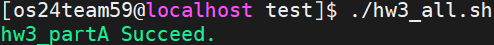